In [1]:
import pandas as pd
import numpy as np
import kagglehub
import os
import seaborn as sns
import matplotlib.pyplot as plt
import math
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score


path = kagglehub.dataset_download("imakash3011/customer-personality-analysis")
file_path = os.path.join(path, 'marketing_campaign.csv')
df = pd.read_csv(file_path, sep='\t')
df.head()

,ID,Year_Birth,Education,Marital_Status,Income,Kidhome,Teenhome,Dt_Customer,Recency,MntWines,...,NumWebVisitsMonth,AcceptedCmp3,AcceptedCmp4,AcceptedCmp5,AcceptedCmp1,AcceptedCmp2,Complain,Z_CostContact,Z_Revenue,Response
0,5524,1957,Graduation,Single,58138.0,0,0,04-09-2012,58,635,...,7,0,0,0,0,0,0,3,11,1
1,2174,1954,Graduation,Single,46344.0,1,1,08-03-2014,38,11,...,5,0,0,0,0,0,0,3,11,0
2,4141,1965,Graduation,Together,71613.0,0,0,21-08-2013,26,426,...,4,0,0,0,0,0,0,3,11,0
3,6182,1984,Graduation,Together,26646.0,1,0,10-02-2014,26,11,...,6,0,0,0,0,0,0,3,11,0
4,5324,1981,PhD,Married,58293.0,1,0,19-01-2014,94,173,...,5,0,0,0,0,0,0,3,11,0


In [2]:
#Numeric Column Cleaning
numeric_cols = df.select_dtypes(include='number').columns.to_list()
cols_to_clean = [col for col in numeric_cols if col != 'ID']
print(df[numeric_cols].describe())

upper_limit = df[cols_to_clean].quantile(0.997)
lower_limit = df[cols_to_clean].quantile(0.003)

df[cols_to_clean] = df[cols_to_clean].clip(lower=lower_limit,upper=upper_limit,axis=1)
print(df[cols_to_clean].describe())

                 ID   Year_Birth         Income      Kidhome     Teenhome  \
count   2240.000000  2240.000000    2216.000000  2240.000000  2240.000000   
mean    5592.159821  1968.805804   52247.251354     0.444196     0.506250   
std     3246.662198    11.984069   25173.076661     0.538398     0.544538   
min        0.000000  1893.000000    1730.000000     0.000000     0.000000   
25%     2828.250000  1959.000000   35303.000000     0.000000     0.000000   
50%     5458.500000  1970.000000   51381.500000     0.000000     0.000000   
75%     8427.750000  1977.000000   68522.000000     1.000000     1.000000   
max    11191.000000  1996.000000  666666.000000     2.000000     2.000000   

           Recency     MntWines    MntFruits  MntMeatProducts  \
count  2240.000000  2240.000000  2240.000000      2240.000000   
mean     49.109375   303.935714    26.302232       166.950000   
std      28.962453   336.597393    39.773434       225.715373   
min       0.000000     0.000000     0.000000  

In [3]:
#Categorical Cleaning
cat_cols = df.select_dtypes(exclude='number').columns.to_list()
cols_to_clean = [col for col in cat_cols if col != 'Dt_Customer']

for i in cols_to_clean:
    print(df[i].unique())

#df_cat[df_cat['Education'] == '2n Cycle'] #convert to masters?
#df_cat[df_cat['Marital_Status'] == 'Absurd'] #convert to single?
#df_cat[df_cat['Marital_Status'] == 'Alone'] #convert to single?
#df_cat[df_cat['Marital_Status'] == 'YOLO'] #convert to single?
#df_cat[df_cat['Marital_Status'] == 'Together'] #convert to married?

df['Education'] = df['Education'].replace({'2n Cycle': 'Master'})
df['Marital_Status'] = df['Marital_Status'].replace({
    'Absurd':'Single',
    'Alone':'Single',
    'YOLO':'Single',
    'Together':'Married'
})

for i in cols_to_clean:
    print(df[i].unique())

['Graduation' 'PhD' 'Master' 'Basic' '2n Cycle']
['Single' 'Together' 'Married' 'Divorced' 'Widow' 'Alone' 'Absurd' 'YOLO']
['Graduation' 'PhD' 'Master' 'Basic']
['Single' 'Married' 'Divorced' 'Widow']


In [4]:
#Dropping remaining missing values
df.dropna(subset=['Income'], inplace=True)

df['Age'] = 2014 - df['Year_Birth'] 
df = df.drop(columns='Year_Birth')

df['Dt_Customer'] = pd.to_datetime(df['Dt_Customer'],format="%d-%m-%Y")
newest_customer = df['Dt_Customer'].max()
df['Tenure_Days'] = (newest_customer - df['Dt_Customer']).dt.days

print(df.head())

     ID   Education Marital_Status   Income  Kidhome  Teenhome Dt_Customer  \
0  5524  Graduation         Single  58138.0        0         0  2012-09-04   
1  2174  Graduation         Single  46344.0        1         1  2014-03-08   
2  4141  Graduation        Married  71613.0        0         0  2013-08-21   
3  6182  Graduation        Married  26646.0        1         0  2014-02-10   
4  5324         PhD        Married  58293.0        1         0  2014-01-19   

   Recency  MntWines  MntFruits  ...  AcceptedCmp4  AcceptedCmp5  \
0       58     635.0         88  ...             0             0   
1       38      11.0          1  ...             0             0   
2       26     426.0         49  ...             0             0   
3       26      11.0          4  ...             0             0   
4       94     173.0         43  ...             0             0   

   AcceptedCmp1  AcceptedCmp2  Complain  Z_CostContact  Z_Revenue  Response  \
0             0             0         0    

In [5]:
#One-Hot Encoding and Scaling
df_prep = pd.get_dummies(df.drop(columns=['ID', 'Dt_Customer']), 
                         columns=['Education', 'Marital_Status'], 
                         prefix=['Edu', 'MS'], 
                         dtype=int)

scaler = StandardScaler()
scaled = scaler.fit_transform(df_prep)
df_scaled = pd.DataFrame(scaled,columns=df_prep.columns)

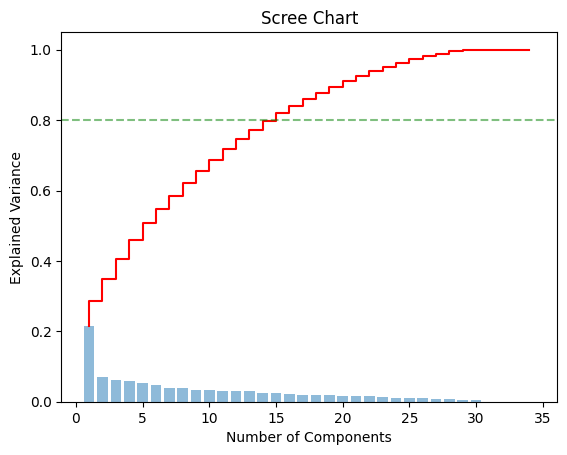

In [6]:
#Determining PCA Component Number
pca = PCA()
pca.fit(df_scaled)

exp_var = pca.explained_variance_ratio_
cum_var = np.cumsum(exp_var)

plt.bar(range(1, len(exp_var) + 1), exp_var, label='Individual Variance',alpha=0.5)
plt.step(range(1,len(exp_var) + 1), cum_var, label='Cumulative Variance',color='red')
plt.axhline(y=0.8, color='green',linestyle='--',alpha=0.5)

plt.title('Scree Chart')
plt.xlabel('Number of Components')
plt.ylabel('Explained Variance')
plt.show()

In [7]:
#Determining Ideal PCA Components
pca_final = PCA(n_components=15)
pca_scores = pca_final.fit_transform(df_scaled)
pca_6 = pca_scores[:, :6]
pca_15 = pca_scores[:, :15]
results = []

for k in [3, 4, 5]:
    kmeans6 = KMeans(n_clusters=k, random_state=2, n_init=20).fit(pca_6)
    score6 = silhouette_score(pca_6, kmeans6.labels_)
    
    kmeans15 = KMeans(n_clusters=k, random_state=2, n_init=20).fit(pca_15)
    score15 = silhouette_score(pca_15, kmeans15.labels_)
    
    results.append({'K': k, 'Score (6 Comp)': score6, 'Score (15 Comp)': score15})

print(pd.DataFrame(results))

   K  Score (6 Comp)  Score (15 Comp)
0  3        0.241468         0.153363
1  4        0.241999         0.150761
2  5        0.221705         0.168761


In [8]:
#Finalizing Analysis and Exporting Results
final_kmeans = KMeans(n_clusters=4,random_state=2,n_init=20)
cluster_labels = final_kmeans.fit_predict(pca_scores[:,:6])

df_results = df.copy()
df_results['Cluster'] = cluster_labels

num_df = df_results.select_dtypes(include='number')
pivot_num = num_df.pivot_table(index='Cluster').T

cat_cols2 = df_results.select_dtypes(exclude='number').columns.to_list()
cat_df = df_results[cat_cols2 + ['Cluster']]

pivot_cat = cat_df.groupby('Cluster').agg(lambda x: x.mode().iloc[0]).T

final_clusters = pd.concat([pivot_num, pivot_cat])

print(df_results['Cluster'].value_counts().sort_index())
print(final_clusters)

final_clusters.to_excel(excel_writer='final_clusters.xlsx')

Cluster
0    146
1    998
2    581
3    491
Name: count, dtype: int64
Cluster                                0                    1  \
AcceptedCmp1                    0.589041                  0.0   
AcceptedCmp2                    0.191781             0.002004   
AcceptedCmp3                    0.178082              0.07515   
AcceptedCmp4                    0.506849             0.008016   
AcceptedCmp5                     0.80137                  0.0   
Age                            42.854226            41.963796   
Complain                        0.006849             0.013026   
ID                           5598.506849          5585.312625   
Income                      80405.075342         34656.916007   
Kidhome                         0.041096             0.796593   
MntFishProducts                72.616438             7.148297   
MntFruits                      49.554795             4.903808   
MntGoldProds                   74.513699            15.397077   
MntMeatProducts     